In [1]:
# sources
# https://stackoverflow.com/questions/11303225/how-to-remove-multiple-indexes-from-a-list-at-the-same-time



In [2]:
# imports

import pandas as pd
import numpy as np
import os
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix



In [3]:
def tokenize_and_preserve_labels(tokenizer, sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [4]:
def process_data(tokenizer, sentences, labels, MAX_LEN, tag2idx, bs, random_seed=42):
    
    tokenized_texts_and_labels = [
        tokenize_and_preserve_labels(tokenizer, sent, labs)
        for sent, labs in zip(sentences, labels)
    ]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                              maxlen=MAX_LEN, dtype="long", value=0.0,
                              truncating="post", padding="post")

    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                         maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                         dtype="long", truncating="post")

    attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

    # split data
    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                                random_state=42, test_size=0.1)
    tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                 random_state=42, test_size=0.1)
    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)

    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

    return train_dataloader, valid_dataloader


In [5]:
def train(train_dataloader, valid_dataloader, epochs=5, dropout=0.3):


    # initialize model
    model = BertForTokenClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",  # bert-base-cased
        num_labels=len(tag2idx),
        output_attentions=False,
        output_hidden_states=False,
        attention_probs_dropout_prob=dropout,  # 0.3
        hidden_dropout_prob=dropout  # 0.3
    )

    model.cuda()

    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )

    epochs = 5
    max_grad_norm = 1.0

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )   


    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    accuracy_values, F1_values, precision_values, recall_values = [], [], [], []

    for e in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                     for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        
        if e == 4:
            print(len(pred_tags))
            print(len(valid_tags))

        accuracy = accuracy_score(valid_tags, pred_tags)
        print("Validation Accuracy: {}".format(accuracy))
        accuracy_values.append(accuracy)

        precision = precision_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Precision-Score: {}".format(precision))
        precision_values.append(precision)

        recall = recall_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Recall-Score: {}".format(recall))
        recall_values.append(recall)

        F1 = f1_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation F1-Score: {}".format(F1))
        F1_values.append(F1)
        print()


    # plotting the metrics

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12, 6)

    # Plot the learning curve.
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")
    plt.plot(accuracy_values, 'g-o', label="accuracy")
    plt.plot(precision_values, 'c-o', label="precision")
    plt.plot(recall_values, 'm-o', label="recall")
    plt.plot(F1_values, 'y-o', label="F1")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Performance")
    plt.legend()

    plt.show()


    return accuracy, precision, recall, F1



Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

Average train loss: 0.3548213594000448
Validation loss: 0.2379458323121071
Validation Accuracy: 0.9032083166356286
Validation Precision-Score: 0.7906213985674175


Epoch:  20%|██        | 1/5 [00:19<01:19, 19.87s/it]

Validation Recall-Score: 0.7994446882035615
Validation F1-Score: 0.7949273574511959

Average train loss: 0.2225179709494114
Validation loss: 0.21879906207323074
Validation Accuracy: 0.9065085688691922
Validation Precision-Score: 0.7930317548458747


Epoch:  40%|████      | 2/5 [00:39<00:59, 19.94s/it]

Validation Recall-Score: 0.8463049743546125
Validation F1-Score: 0.8159885778088702

Average train loss: 0.18803547280417246
Validation loss: 0.20355907529592515
Validation Accuracy: 0.9171636689375545
Validation Precision-Score: 0.8248619474406959


Epoch:  60%|██████    | 3/5 [01:01<00:41, 20.72s/it]

Validation Recall-Score: 0.8120294741826584
Validation F1-Score: 0.8182468936196554

Average train loss: 0.17422706202011218
Validation loss: 0.20497852563858032
Validation Accuracy: 0.9150892246764574
Validation Precision-Score: 0.8121432745003223


Epoch:  80%|████████  | 4/5 [01:21<00:20, 20.50s/it]

Validation Recall-Score: 0.840726750555821
Validation F1-Score: 0.8254348521782492

Average train loss: 0.16462197815152732
Validation loss: 0.2069702371954918
42421
42421
Validation Accuracy: 0.9150656514462177
Validation Precision-Score: 0.8124175401034563


Epoch: 100%|██████████| 5/5 [01:41<00:00, 20.38s/it]

Validation Recall-Score: 0.8389327687174131
Validation F1-Score: 0.8248140098971605



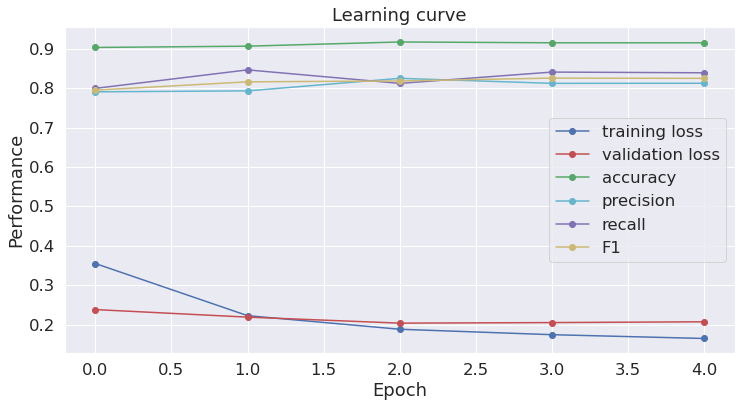

In [6]:
# main program

# reading in dataset which contains all tokens, and info for every token.
df_orig = pd.read_pickle('df_orig.pickle')

# groups tokens into their corresponding abstracts. groups labels into their corresponding abstracts.
def abstract_labels(df_orig):
    abstracts = []
    labels = []
    df_abs_groups = df_orig.groupby('PMID')
    for name, group in df_abs_groups: # no order
        group_labs = group.gold.tolist()
        s = group.head(1).abstract.tolist()[0]
        
        # remove None type values from label and abstracts. Snorkel does the same.
        remove_indices = [i for i, v in enumerate(group_labs) if v == None]
        group_labs = [i for j, i in enumerate(group_labs) if j not in remove_indices]
        s = [i for j, i in enumerate(s) if j not in remove_indices]
        
        abstracts.append(s)
        labels.append(group_labs)
    
    return abstracts, labels

# two corresponding lists of abstracts and labels for each abtract
abstracts, labels = abstract_labels(df_orig)


# define parameters
MAX_LEN = 512
bs = 12

# define labels
tag_values = ['0', '1', 'PAD']
tag2idx = {'0': 0, '1': 1, 'PAD': 2}
    

# device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

# prepare data
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT',
                                          do_lower_case=False)  # bert-base-cased

train_dataloader, valid_dataloader = process_data(tokenizer, abstracts, labels, MAX_LEN, tag2idx, bs,
                                                  random_seed=42)

# train
accuracy, precision, recall, F1 = train(train_dataloader, valid_dataloader, epochs=5)

    